# Grating coupler for Gaussian source (Gs)

In [1]:
import meep as mp
import math
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn")
mp.verbosity(0)

/tmp/ipykernel_23826/117675783.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


1

## Grating coupler simulation Configuration

<Axes: xlabel='X', ylabel='Y'>

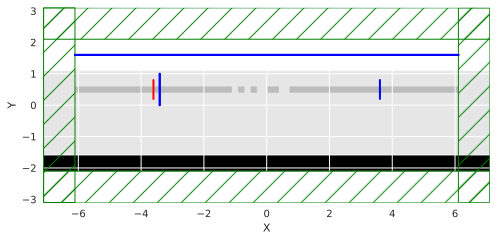

In [5]:
# if True compute flux (Gaussian source), if False compute DFT (Continue source)
compute_flux = True
# size of input and output waveguide
w = 0.5
h = 0.2

# resolution size
grid = 0.02
resolution = 1 / grid

# thickness of PML
dpml = 1

##################### length parameter ################
input_wvg_length = 5
output_wvg_length = 5

# period = 0.707  # period of grating coupler
period = 0.4  # period of grating coupler
duty_cycle = 0.53  # duty cycle of grating coupler
period_2 = 0.707  # period of grating coupler
duty_cycle_2 = 0.53  # duty cycle of grating coupler
number_period = 2  # number of period of grating coupler
sx = (
    input_wvg_length
    + period * number_period
    + period_2 * number_period
    + output_wvg_length
    + 2 * dpml
)

##################### height parameter ################
Substrate_thickness = 0.5
BOX_thickness = 2
TOX_thickness = 0.7
near_field_height = 1
sy = BOX_thickness + TOX_thickness + Substrate_thickness + near_field_height + 2 * dpml

cell = mp.Vector3(sx, sy, 0)

# Material setting
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.44)
SiN = mp.Medium(index=1.96)

####################### geometry ##########################
Substrate_geo = mp.Block(
    material=Si,
    center=mp.Vector3(y=-0.5 * sy + 0.5 * Substrate_thickness + dpml),
    size=mp.Vector3(sx, Substrate_thickness),
)
BOX_geo = mp.Block(
    material=SiO2,
    center=mp.Vector3(y=-0.5 * sy + Substrate_thickness + 0.5 * BOX_thickness + dpml),
    size=mp.Vector3(sx, BOX_thickness),
)
TOX_geo = mp.Block(
    material=SiO2,
    center=mp.Vector3(
        y=-0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * TOX_thickness + dpml
    ),
    size=mp.Vector3(sx, TOX_thickness),
)
input_waveguide_geo = mp.Block(
    material=SiN,
    center=mp.Vector3(
        -0.5 * sx + 0.5 * input_wvg_length + dpml,
        -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
    ),
    size=mp.Vector3(input_wvg_length, h),
)
output_waveguide_geo = mp.Block(
    material=SiN,
    center=mp.Vector3(
        0.5 * sx - 0.5 * output_wvg_length - dpml,
        -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
    ),
    size=mp.Vector3(output_wvg_length, h),
)

grating_coupler_geo = []
for ii in range(1, number_period + 1):
    grating_coupler_geo.append(
        mp.Block(
            material=SiN,
            center=mp.Vector3(
                -0.5 * sx
                + input_wvg_length
                + ii * period
                - duty_cycle * period / 2
                + dpml,
                -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
            ),
            size=mp.Vector3(duty_cycle * period, h),
        )
    )

grating_coupler_geo_2 = []
for ii in range(1, number_period + 1):
    grating_coupler_geo_2.append(
        mp.Block(
            material=SiN,
            center=mp.Vector3(
                -0.5 * sx
                + input_wvg_length
                + number_period * period
                + ii * period_2
                - duty_cycle_2 * period_2 / 2
                + dpml,
                -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
            ),
            size=mp.Vector3(duty_cycle_2 * period_2, h),
        )
    )

geometry = [
    Substrate_geo,
    BOX_geo,
    TOX_geo,
    input_waveguide_geo,
    output_waveguide_geo,
    *grating_coupler_geo,
    *grating_coupler_geo_2,
]

####################### geometry ##########################

####################### Sources ##########################
wvl = 0.785
fcen = 1 / wvl
fwidth = 0.2 * fcen
kpoint = mp.Vector3(1, 0, 0)

sources = [
    mp.EigenModeSource(
        mp.GaussianSource(frequency=fcen, fwidth=fwidth),
        center=input_waveguide_geo.center,
        size=mp.Vector3(0, 3 * h),
        eig_band=1,
        eig_parity=mp.EVEN_Y + mp.ODD_Z,
        eig_match_freq=True,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
    )
]
# set nomrlized source: amplitude is 1 -> flux is 1
sources[0].amplitude = 1 / mp.GaussianSource(fcen, fwidth=fwidth).fourier_transform(
    fcen
)

####################### Sources ##########################

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell,
    boundary_layers=[mp.PML(dpml)],
    sources=sources,
    geometry=geometry,
)

# ############### Monitor ###################
nfreq = 1

# src_region
src_region = mp.FluxRegion(
    center=input_waveguide_geo.center + mp.Vector3(0.2, 0, 0),
    size=mp.Vector3(0, 5 * h, 0),
)
src_flux = sim.add_mode_monitor(fcen, 0, 1, src_region)

src_dft = sim.add_dft_fields(
    [mp.Ez], fcen, fwidth, nfreq, center=src_region.center, size=src_region.size
)

# near_field_region
near_region = mp.FluxRegion(
    center=mp.Vector3(0, 0.5 * sy - dpml - 0.5 * near_field_height, 0),
    size=mp.Vector3(sx - 2 * dpml, 0),
)

near_field = sim.add_mode_monitor(
    fcen,
    fwidth,
    nfreq,
    near_region,
)

near_dft = sim.add_dft_fields(
    [mp.Ez], fcen, fwidth, nfreq, center=near_region.center, size=near_region.size
)

# near2far_field
n2f_field = sim.add_near2far(
    fcen,
    0,
    nfreq,
    near_region,
)

out_region = mp.FluxRegion(
    center=mp.Vector3(output_waveguide_geo.center.x, output_waveguide_geo.center.y, 0),
    size=mp.Vector3(0, 3 * h, 0),
)
out_field = sim.add_mode_monitor(
    fcen,
    0,
    1,
    out_region,
)
# geometry plot
sim.plot2D()

## Simulation run and save animate

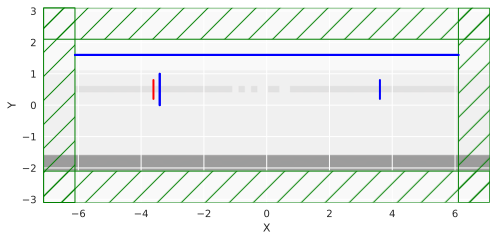

In [6]:
# run simulation
# sim.reset_meep()

# monitor point
mpt = mp.Vector3(0.5 * sx - dpml - 1, output_waveguide_geo.center.y)

f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)

sim.run(
    mp.at_every(1, Animate),
    until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mpt, 1e-5),
)


In [45]:
filename = "base_simulation_GS.mp4"
Animate.to_mp4(10, filename)


In [35]:
from IPython.display import Video

Video(filename)


## get mode date

In [25]:
# input mode
input_mode = sim.get_eigenmode_coefficients(src_flux, [1], eig_parity=mp.EVEN_Y)
input_flux = mp.get_fluxes(src_flux)
print(abs(input_mode.alpha[0, 0, 0]) ** 2)
print(input_flux)


0.9560943250541565
[0.9479590234583369]


In [26]:
# input mode
output_mode = sim.get_eigenmode_coefficients(out_field, [1], eig_parity=mp.EVEN_Y)
output_flux = mp.get_fluxes(out_field)
print(abs(output_mode.alpha[0, 0, 0]) ** 2)
print(output_flux)

0.522197611038899
[0.5427083371502873]


/home/chen/miniconda3/envs/mp/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, '$ E_z $ of input mode at 785nm wavelength')

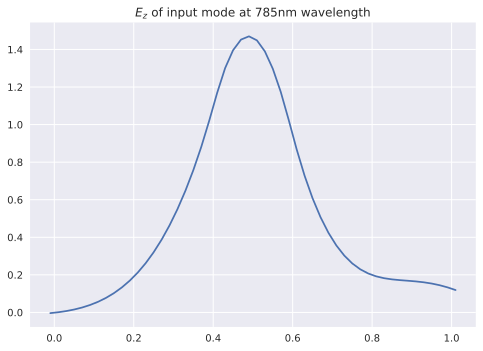

In [27]:
input_dft = sim.get_dft_array(src_dft, mp.Ez, 0)
[x, y, z, w] = sim.get_array_metadata(dft_cell=src_dft)
plt.plot(y, input_dft)
plt.title(r'$ E_z $ of input mode at 785nm wavelength')

## near field mode

In [28]:
near_field_flux = mp.get_fluxes(near_field)
print(f'The power of near_field is {near_field_flux}')


The power of near_field is [0.23386846045635643]


**Ez in the near field**

Text(0, 0.5, '$ E_z $')

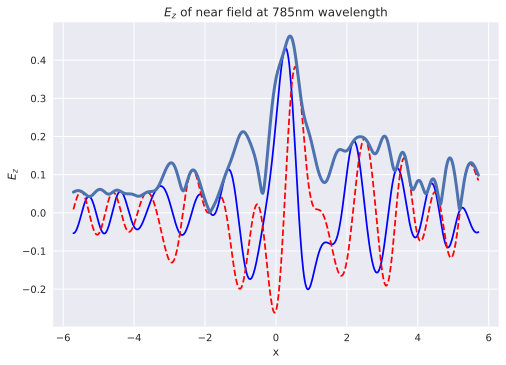

In [29]:
output_dft = sim.get_dft_array(near_dft, mp.Ez, 0)
[x, y, z, w] = sim.get_array_metadata(dft_cell=near_dft)

figure, ax = plt.subplots()
plt.plot(x, np.real(output_dft), '-b')
plt.plot(x, np.imag(output_dft), '--r')
plt.plot(x, np.abs(output_dft), linewidth=3)

plt.title(r"$ E_z $ of near field at 785nm wavelength")
ax.set_xlabel("x")
ax.set_ylabel(r"$ E_z $")

In [24]:
shift_output_dft = np.roll(output_dft, 100)
np.abs(np.sum(np.squeeze(output_dft) * np.conj(output_dft)))

40.439663200696785

**DFT of near field**

The angle of maximum intensity is 28.70709866393521


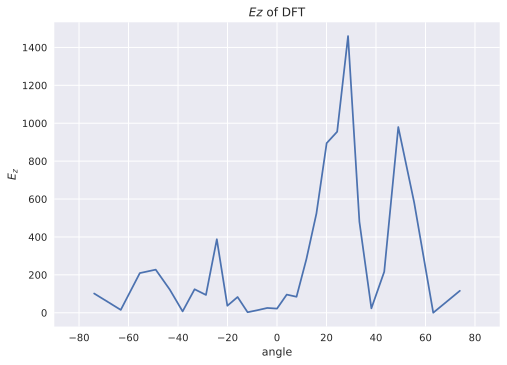

In [30]:
# dft ot near field
kx = np.fft.fftshift(np.fft.fftfreq(len(x), grid))
near_field_fft = np.fft.fftshift(np.fft.fft(output_dft))

k = 1 / wvl
kx[np.abs(kx) > k] = np.nan
angle = np.arcsin(kx / k) *180/np.pi

figure, ax = plt.subplots()
plt.plot(angle, np.abs(near_field_fft) ** 2, "-")
plt.title(r"$ Ez $ of DFT")
ax.set_xlabel("angle")
ax.set_ylabel(r"$ E_z $")
ax.set_xlim(-90, 90)

max_index = np.argmax(np.abs(near_field_fft) ** 2)
print(f'The angle of maximum intensity is {angle[max_index]}')

**far field**

Output_angle of grating coupler: -24.15526813049959 degree


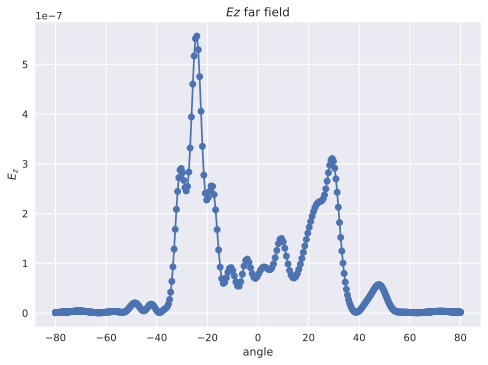

In [7]:
ff_distance = 1e6  # far-field distance from near-field monitor
ff_angle = 80  # far-field cone angle
ff_npts = 1000  # number of far-field points
# single-side far-field length
ff_length = ff_distance * math.tan(math.radians(ff_angle))  # far-field length
# [-ff_length, ff_length]
ff_lengths = np.linspace(-ff_length, ff_length, ff_npts)  # far-field lengths
# resolution
ff_res = ff_npts / (2 * ff_length)  # far-field length resolution

ff = sim.get_farfields(
    n2f_field,
    ff_res,
    center=mp.Vector3(0, ff_distance),
    size=mp.Vector3(x=2 * ff_length),
)
# [-angle, angle]
angles = [math.degrees(math.atan(f)) for f in ff_lengths / ff_distance]
rel_enh = np.abs(ff["Ez"]) ** 2

figure, ax = plt.subplots()
plt.plot(angles, rel_enh, "-o")
plt.title(r"$ Ez $ far field")
ax.set_xlabel("angle")
ax.set_ylabel(r"$ E_z $")

index = np.argmax(rel_enh)
print(f"Output_angle of grating coupler: {angles[index]} degree")

In [ ]:
near_field_flux[0]

In [14]:
print(np.sum(5*rel_enh))

0.0035672157721405888


## $ E_z $ profile

     block, center = (0,-1.85,0)
          size (26.14,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.6,0)
          size (26.14,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.75,0)
          size (26.14,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-9.57,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8416)
     block, center = (9.57,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8416)
     block, center = (-6.55036,0.5,0)
          size (0.37471,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric 

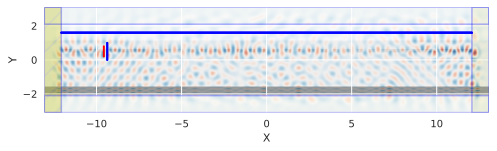

In [15]:
sim.plot2D(
    fields=mp.Ez,
    boundary_parameters={
        "linewidth": 1.5,
        "facecolor": "y",
        "edgecolor": "b",
        "alpha": 0.3,
    },
)
Ez = sim.get_efield_z()
np.savetxt('Ez.txt', Ez)